In [1]:
# M1 -> Cleaning, tidying and visualizations
# M2 -> Feature Engineering and pipeline
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
from sklearn import preprocessing
import math
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
#for reproducability
np.random.seed(42)

## Reading Data

# Life Expectancy Dataset

In [2]:
root_path_happiness = 'data/Happiness_Dataset'
world_happiness_2015_df = pd.read_csv(root_path_happiness + '/2015.csv')
world_happiness_2016_df = pd.read_csv(root_path_happiness + '/2016.csv')
world_happiness_2017_df = pd.read_csv(root_path_happiness + '/2017.csv')
world_happiness_2018_df = pd.read_csv(root_path_happiness + '/2018.csv')
world_happiness_2019_df = pd.read_csv(root_path_happiness + '/2019.csv')
life_expectancy_df = pd.read_csv('data/Life Expectancy Data.csv')
country_data_df = pd.read_csv('data/250 Country Data.csv')

#### Helper functions

In [3]:
def visualiseNaNCount(df):
  #Visualise NaNs
    numberNulls=[]
    columnNames=[]
    for (columnName, columnData) in df.iteritems():
            nan = df[columnName].isnull().sum()
            numberNulls.append(nan)
            columnNames.append(columnName)

    fig, ax = plt.subplots()
    ax.set_title('NaN count', fontdict={'fontsize': 12, 'fontweight': 'medium'})
    plt.bar(columnNames, numberNulls)
    plt.xticks(rotation=90)

    plt.show()

####  Taking a look at the data

In [4]:
life_expectancy_df.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938.000000,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,2904.000000,2938.000000,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
mean,2007.518720,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,4.613841,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,20.044034,160.445548,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,19.300000,0.000000,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,2008.000000,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,2012.000000,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,56.200000,28.000000,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.60000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


## Data Cleaning

## Tidying

We need all column headers to represent variables, the problem is in the columns that represent stats about diseases

According to dataset description, the columns..
* measles represents the number of reported cases per 1000 
* HIV/AID represents the number of deaths per 1 000 live births HIV/AIDS (0-4 years)

We can rename the above to columns to be more reflective of what they represent, furthermore it seems that it would be pointless to melt them as they are not measured in the same units plus they are already variables

In addition, columns Hepatitis B, Polio, and Diphtheria represent the percentage of immunization coverage among 1-year-olds. These three columns can be melted in order to be represented as 2 columns: disease, immunization.

The columns infant deaths, number of reported measles cases, and under-five deaths are nearly all missing data. They are not relevant to our research questions too. This gave us a good reason to drop them since imputing them would provide unnecessary noise in the data. In addition after research on Kaggle and exploring the data visually (scanning rows and columns) it has been concluded that BMI contains too many wrong values. It does not relate to our research questions so we will be dropping it too. In addition, population column is full of nans, and population is really hard to impute from the given variables; in addition the column population is present in the 250 countries dataset, and does not contain nulls. We can use it from there.

There are values of 0 for infant deaths

This does not make sense and probably was supposed to be a nan value.  This also applies to cases of measles, percentage expenditure ,years of schooling, and under five deaths.

Also we have noticed that some countries are incorrectly labelled as developing when they are developed so we correct that.

We define functions to do that for us

In [5]:
def tidy_life_expectancy(life_expectancy_df):
    life_expectancy_df.columns = life_expectancy_df.columns.str.lstrip()
    life_expectancy_df.columns = life_expectancy_df.columns.str.rstrip()
    life_expectancy_df.rename(columns = {'HIV/AIDS':'HIV/AIDS Deaths'}, inplace = True) 
    life_expectancy_df.rename(columns = {'Measles':'Number of reported Measles cases'}, inplace = True) 
    #diseses_columns = ['Hepatitis B','Polio','Diphtheria','Measles', 'HIV/AIDS']
    #diseases_count_columns = ['Measles', 'HIV/AIDS']
    immunization_columns = ['Hepatitis B','Polio','Diphtheria']
    #melt immunization
    new_columns =  [column for column in list(life_expectancy_df.columns) if not(column in immunization_columns)]  #print([s for s in l if s != 'Bob'])
    life_expectancy_df_melted = pd.melt(life_expectancy_df,id_vars=new_columns,var_name="Disease", value_name="Immunization coverage")
    life_expectancy_df_melted.head()
    return life_expectancy_df_melted
    #Measles - number of reported cases per 1000 population
    #HIV/AID Deaths per 1 000 live births HIV/AIDS (0-4 years)
    #Hepatitis B (HepB) immunization coverage among 1-year-olds (%)
    #Polio (Pol3) immunization coverage among 1-year-olds (%)
    #Diphtheria tetanus toxoid and pertussis (DTP3) immunization coverage among 1-year-olds (%)
    


In [6]:
def turn_inaccurate_to_nan(tidy_life_expectancy_df):
    tidy_life_expectancy_df['infant deaths'].replace({0: np.nan}, inplace = True)
    tidy_life_expectancy_df['under-five deaths'].replace({0: np.nan}, inplace = True)
    tidy_life_expectancy_df['Schooling'].replace({0: np.nan},inplace = True)
    tidy_life_expectancy_df['percentage expenditure'].replace({0: np.nan}, inplace = True)
    tidy_life_expectancy_df['Number of reported Measles cases'].replace({0: np.nan},inplace = True)
    
    irrelevant_columns = ["infant deaths", "under-five deaths","Number of reported Measles cases","BMI","Alcohol","thinness  1-19 years","thinness 5-9 years","Total expenditure","Population" ]
    tidy_life_expectancy_df.drop(columns=irrelevant_columns, inplace = True)
    return tidy_life_expectancy_df
    #visualiseNaNCount(life_expectancy_df_melted)

In [7]:
def correct_data(tidy_life_expectancy_df):
    #correcting some values
    indices_canada = tidy_life_expectancy_df.loc[tidy_life_expectancy_df["Country"]=="Canada"].index
    tidy_life_expectancy_df.loc[indices_canada, ("Status")] = "Developed"

    indices_canada = tidy_life_expectancy_df.loc[tidy_life_expectancy_df["Country"]=="Greece"].index
    tidy_life_expectancy_df.loc[indices_canada, ("Status")] = "Developed"

    tidy_life_expectancy_df.loc[tidy_life_expectancy_df["Country"]=="Greece"].head()
    
    return tidy_life_expectancy_df

In [8]:

tidy_life_expectancy_df = tidy_life_expectancy(life_expectancy_df)
corrected_life_expectancy_df = turn_inaccurate_to_nan(tidy_life_expectancy_df)
life_expectancy_df_melted = correct_data(corrected_life_expectancy_df)

life_expectancy_df_melted.describe()

,Year,Life expectancy,Adult Mortality,percentage expenditure,HIV/AIDS Deaths,GDP,Income composition of resources,Schooling,Immunization coverage
count,8814.000000,8784.000000,8784.000000,6981.000000,8814.000000,7470.000000,8313.000000,8241.000000,8223.000000
mean,2007.518720,69.224932,164.796448,932.093814,1.742103,7483.158469,0.627551,12.115035,82.003040
std,4.613317,9.522783,124.277927,2192.656248,5.077208,14268.258627,0.210878,3.148567,24.023596
min,2000.000000,36.300000,1.000000,0.099872,0.100000,1.681350,0.000000,2.800000,1.000000
25%,2004.000000,63.100000,74.000000,36.199487,0.100000,463.852618,0.493000,10.200000,78.000000
50%,2008.000000,72.100000,144.000000,155.195208,0.100000,1766.947595,0.677000,12.400000,93.000000
75%,2012.000000,75.700000,228.000000,630.388356,0.800000,5918.198980,0.779000,14.300000,97.000000
max,2015.000000,89.000000,723.000000,19479.911610,50.600000,119172.741800,0.948000,20.700000,99.000000


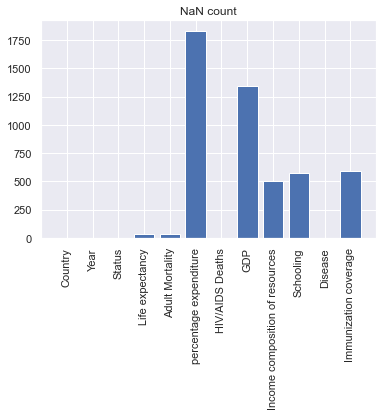

In [9]:
visualiseNaNCount(life_expectancy_df_melted)

In [10]:
def plot_nan_vs_feature(feature):
    number_nans_life_expectancy_developed = life_expectancy_df_melted[life_expectancy_df_melted["Status"]=="Developed"][feature].isna().sum()
    number_nans_life_expectancy_developing = life_expectancy_df_melted[life_expectancy_df_melted["Status"]=="Developing"][feature].isna().sum()
    status = ["Developed","Developing"]
    count = [number_nans_life_expectancy_developed,number_nans_life_expectancy_developing]
    fig, ax = plt.subplots()
    ax.bar(status,count)
    ax.set_title(feature + "nan count in developing vs developed countries")
    ax.set_xlabel('Status')
    ax.set_ylabel('Count')
    plt.show()

As we can see, the number of nulls is pretty high in population and GDP columns. Also in the total expenditure, income composition, schooling, immunization, and alcohol.

In order to treat the nulls, we have to use an imputation method. In this dataset we opt to imputation rather than dropping in order not to cause a bias/ data loss.
We examine the columns to see what is the best treatment method for each one.

#### Lets start with life expectancy
we start with the column with the least nans in case we resort to using it to impute other variables.

Is life expectancy missing completely at random or is there some relationship between missing life expectancies and other variables?

Perhaps developing counteries are less likely to report the life expectancy, perhaps due to limited surveying tools or overlooking the importance of keeping records

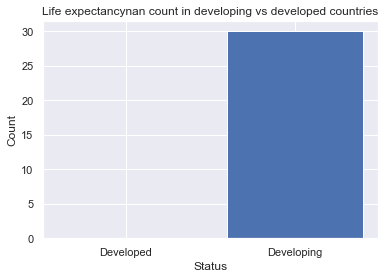

In [11]:
plot_nan_vs_feature("Life expectancy")

Clearly, there is a strong relationship between the status of a country and reporting life expectancy.

In order to impute the nans, we need to see the relationship between life expectancy and other variables. A strong correlation between life expectancy and another variable means we can use it to estimate the nan by regression perhaps.


##### maybe if we can break the records down by year we would see an even stronger correlation
Intuitively, adult mortality and HIV/AIDS deaths would have a negative correletaion with life expectancy. As higher number of deaths (adult mortality) usually implies death of causes other than old age, whereas HIV/AIDS would cause a higher number of unnatural deaths too. We plot scatter plots to see if there is a correlation.

Below we break the data down by year then plot scatter plots to show how life expectancy correlates with other variables


In [12]:
#plots scatter plots for every year to show how feature_1 and feature_2 correlate for a developing or developed countries
def plot_scatter_by_year(feature_1, feature_2, status):
    
    status_df = life_expectancy_df_melted.loc[life_expectancy_df_melted["Status"]==status]
    status_df_by_year ={}
    years = status_df.Year.unique()
    for year in years:
        status_df_by_year[str(year)] = status_df[status_df["Year"]==year]
    print(feature_1 + " and "+ feature_2+" correlation") 
    for i in range (1, 17):
        plt.subplot(4, 4, i)
        plt.scatter(status_df_by_year[str(years[i-1])][feature_1], status_df_by_year[str(years[i-1])][feature_2], s=5)
        #plt.text(0.5,0.5, str((2, 3, i)), ha='center', fontsize = 10)
        
        plt.tight_layout()
    plt.show()
    

Life expectancy and Adult Mortality correlation


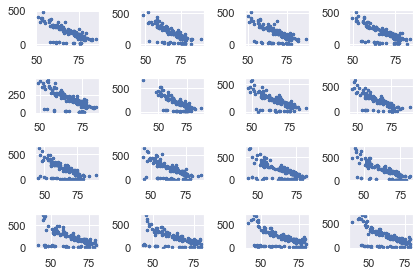

In [13]:
plot_scatter_by_year("Life expectancy", "Adult Mortality", "Developing")


#### Great! There is a strong negative correlation clearly between life expectancy and adult mortality. There are a few countries that do not follow the trend, lets explore why first in order to be able to know when and where we can generalise this relation. Furthermore, lets explore HIV/AIDS correlation

Life expectancy and HIV/AIDS Deaths correlation


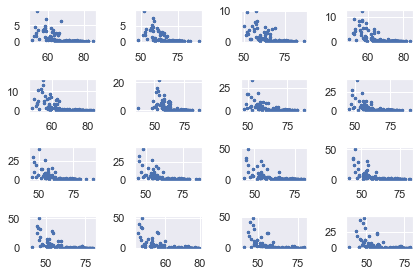

In [14]:
plot_scatter_by_year("Life expectancy", "HIV/AIDS Deaths", "Developing")

In [15]:
life_expectancy_df_melted.loc[life_expectancy_df_melted["Status"]=="Developing"].corr()["Life expectancy"]

Year                               0.189426
Life expectancy                    1.000000
Adult Mortality                   -0.657061
percentage expenditure             0.381793
HIV/AIDS Deaths                   -0.573542
GDP                                0.364453
Income composition of resources    0.632803
Schooling                          0.722065
Immunization coverage              0.400195
Name: Life expectancy, dtype: float64

Life expectancy positively correlates with years of schooling and income composition of resources. This also makes sense as higher education leads to more awareness and people are able to take care of their health better. Also income composition of resources represents an aspect of the human developement index which is by definition a statistical index composed of life expectancy, education (Literacy Rate, Gross Enrollment Ratio at different levels and Net Attendance Ratio), and per capita income indicators, which are used to rank countries into four tiers of human development. A country scores a higher HDI when the lifespan is higher, the education level is higher, and the gross national income (GNI) per capita is higher. In other words a higher HDI means a better quality of life.

Life expectancy and Income composition of resources correlation


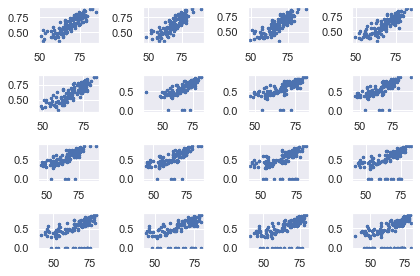

In [16]:
plot_scatter_by_year("Life expectancy", "Income composition of resources", "Developing")

Life expectancy and Schooling correlation


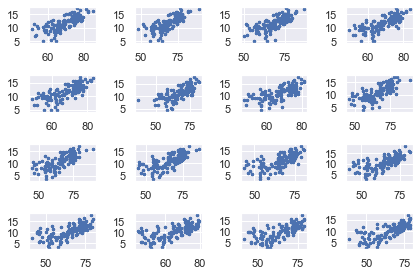

In [17]:
plot_scatter_by_year("Life expectancy", "Schooling", "Developing")

### Strong positive correlation from the above plots :)

We want to impute the life expectancy missing values. Where, the predictors (X) will be the features that strongly correlate with life expectancy and the life expectancy will be the Y to be predicted. 
The problem is, the predictors themselves have some values that contain nulls (they are in low number though). We need a way to impute these values and use them. Therefore we use multiple imputation using chained equations (MICE). In this method, we fill nans with a placeholder value. How to choose a placeholder? There are many ways such as: random sample, mean, median, mode. For skewed distributions it is best to use median, otherwise mean would work well. Then we pick a column, and revert the placeholder values to nans again and use the other columns to predict this value using regression.


#### Distribution
To choose a way to select a placeholder value, we would like to see how the variables are distributed. To view the distribution we need to plot a histogram. In order to be able to do that we need to determine an appropriate bin size, as a bin size too big or too small can lead to misleading information. One way to do that is to use the Freedman-Diaconis’s Rule. This formula uses the interquartile range (IQR), where the bin width = 2(IQR) $\sqrt[-3]{n}$ where n is the total number of observations. We implement a method to calculate this below.

In [18]:
def FreedmanRule(input_vector):
    #calculate IQR
    #print(input_vector)
    #using nan percentile to ignore nans
    q75, q25 = np.nanpercentile(input_vector, [75 ,25])
    #print(q25)
    iqr = q75 - q25
    #calculate Bin width
    bin_width = (2* iqr) / int(round(len(input_vector) ** (1. / 3)))
    return bin_width

Next, lets define a function that can draw a variable distribution

In [19]:
def drawDist(variable_to_display, title):
    
    bin_width = FreedmanRule(variable_to_display)
    num_bins = math.ceil((variable_to_display.max() - variable_to_display.min())/bin_width)
    ax = variable_to_display.plot.hist(bins=num_bins, alpha=0.5)
    ax.set_title(title)

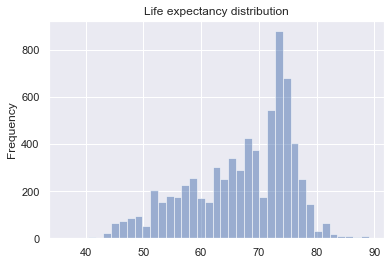

In [20]:
drawDist(life_expectancy_df_melted[ life_expectancy_df_melted['Status'] == "Developing"]["Life expectancy"], "Life expectancy distribution")

Life expectancy distribution is slightly skewed, making median a suitable placeholder.

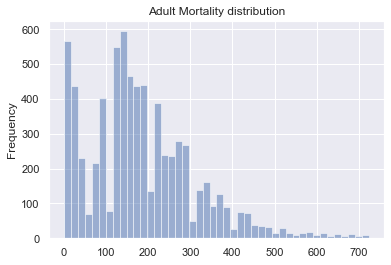

In [21]:
drawDist(life_expectancy_df_melted[ life_expectancy_df_melted['Status'] == "Developing"]["Adult Mortality"], "Adult Mortality distribution")

There is a greater skew here towards the left. In addition to it being bimodal. This also makes median a more suitable fit for a temporary placeholder than the mean.

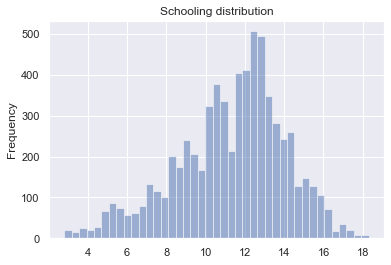

In [22]:
drawDist(life_expectancy_df_melted[ life_expectancy_df_melted['Status'] == "Developing"]['Schooling'], "Schooling distribution")

The distribution has a very slight skew, therefore we will also use the median

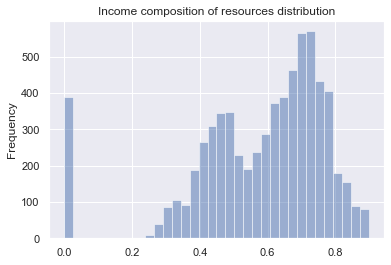

In [23]:
drawDist(life_expectancy_df_melted[ life_expectancy_df_melted['Status'] == "Developing"]['Income composition of resources'], "Income composition of resources distribution")

The distribution is pretty strange as there is a discontinuity. Perhaps samples drawn at random would be the suitable placeholders. Random sampling is selected in order to preserve the distribution as much as possible. It should be noted that we made sure that the 0 value is not a null by checking the documentation of the dataset.

In order to impute the rest of the variables, we need to check the correlation between the variables and one another.

In [24]:
life_expectancy_df_melted.corr()

,Year,Life expectancy,Adult Mortality,percentage expenditure,HIV/AIDS Deaths,GDP,Income composition of resources,Schooling,Immunization coverage
Year,1.000000,0.170033,-0.079052,0.087141,-0.139741,0.101620,0.243468,0.193132,0.108785
Life expectancy,0.170033,1.000000,-0.696359,0.427902,-0.556556,0.461455,0.724776,0.783514,0.409993
Adult Mortality,-0.079052,-0.696359,1.000000,-0.263363,0.523821,-0.296049,-0.457626,-0.463403,-0.241336
percentage expenditure,0.087141,0.427902,-0.263363,1.000000,-0.117728,0.923014,0.414441,0.435542,0.129457
HIV/AIDS Deaths,-0.139741,-0.556556,0.523821,-0.117728,1.000000,-0.136491,-0.249519,-0.237752,-0.146539
GDP,0.101620,0.461455,-0.296049,0.923014,-0.136491,1.000000,0.460341,0.464407,0.172128
Income composition of resources,0.243468,0.724776,-0.457626,0.414441,-0.249519,0.460341,1.000000,0.779310,0.334620
Schooling,0.193132,0.783514,-0.463403,0.435542,-0.237752,0.464407,0.779310,1.000000,0.376842
Immunization coverage,0.108785,0.409993,-0.241336,0.129457,-0.146539,0.172128,0.334620,0.376842,1.000000


We take the variables that correlate the most with the features we are trying to impute. We impute the features with the lowest number of nans first. We must first view the distribution of the variables first.

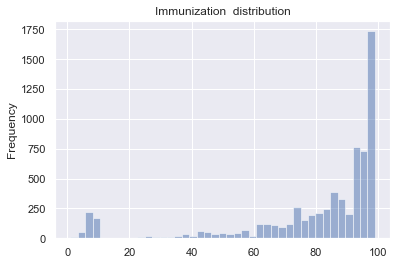

In [25]:
drawDist(life_expectancy_df_melted[ life_expectancy_df_melted['Status'] == "Developing"]['Immunization coverage'], "Immunization  distribution")

Very skewed

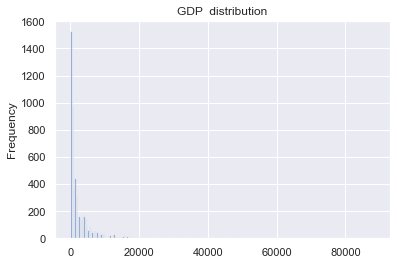

In [26]:
drawDist(life_expectancy_df_melted[ life_expectancy_df_melted['Status'] == "Developing"]['GDP'], "GDP  distribution")

Very sharp skew

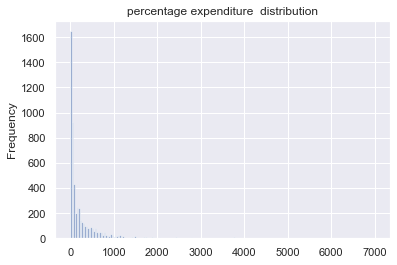

In [27]:
drawDist(life_expectancy_df_melted[ life_expectancy_df_melted['Status'] == "Developing"]['percentage expenditure'], "percentage expenditure  distribution")

Also a very sharp skew which implies that we should be using the median

#### Imputation


We define a function that can impute the missing values using median value. The median value will act as a temporary placeholder as described above. The values that are not null will be kept the same

In [28]:
def medianImputation(dataframe, feature):
    median = dataframe[feature].median()
    dataframe.loc[dataframe[feature].isnull(), (feature + '_temp')] = median
    return dataframe

Below is a brief demo of how median imputation works. Below we are trying to fill col3 with placeholders so we create a new column col3_temp and fill it with the placeholders (median) in place of nulls and leave other values as is.

In [29]:
dataframe_demo = pd.DataFrame({'col1': [1, np.nan,2], 'col2': [3, 3,4],'col3': [3,2, np.nan]})
print("Dataframe before \n")
print(dataframe_demo.head())
dataframe_demo["col3_temp"] = dataframe_demo["col3"]
dataframe_demo =medianImputation(dataframe_demo, "col3")
print("\n")
print("Dataframe after \n")
dataframe_demo

Dataframe before 

   col1  col2  col3
0   1.0     3   3.0
1   NaN     3   2.0
2   2.0     4   NaN


Dataframe after 



,col1,col2,col3,col3_temp
0,1.0,3,3.0,3.0
1,NaN,3,2.0,2.0
2,2.0,4,NaN,2.5


Implementing random imputer. It selects a number of obervations at random from the sample (non null observations). These are used for the placeholder values. Since we are randomising a process we specified a random seed above (very first cell) using np.random.seed(42). This allows for reproducible results due to the pseudo-random nature of computers.

In [30]:
def randomImputation(dataframe, feature):

    number_missing = dataframe[feature].isnull().sum()
    observed_values = dataframe.loc[dataframe[feature].notnull(), (feature)]
    dataframe.loc[dataframe[feature].isnull(), (feature + '_temp')] = np.random.choice(observed_values, number_missing, replace = True)

    return dataframe

Below we create a model that can be used to impute the data

In [31]:
#in: dataframe, features used by the model, feature that the model will predict, the type of model to fit, whether reshaping is needed or not
#output: fitted model, ready to be used to predict feature
def create_model(dataframe,params, feature_to_impute, model_type , reshape):
    
    if(model_type == "LR"):
        model = linear_model.LinearRegression()
    else:
        model = KNeighborsRegressor(n_neighbors=2)
    #fit model on data
    if(reshape):
        XTrain =np.array(dataframe[params]).reshape(-1, 1)
    else:
        XTrain = dataframe[params]
        
        #print(XTrain.isna().sum())
    model.fit(X = XTrain , y = dataframe[feature_to_impute + '_temp'])
    return model

We will be imputing features, so we will be needing to continously merge what we have imputed into the original dataframe -> drop the old columns that contain null values and replace them by imputed columns

In [32]:
def merge_dataframes(dataframe,original_dataframe,columns_to_drop, column_old, column_new, status_to_keep):
    #dropping temporary columns
    dataframe.drop(columns=columns_to_drop,inplace = True)
    #rename the imputed column
    dataframe.rename(columns = {column_old:column_new}, inplace = True)
    #drop the old part from the original data set 
    original_dataframe = original_dataframe[original_dataframe['Status'] == status_to_keep]
    original_dataframe=pd.concat([dataframe, original_dataframe], sort = False)
    #print("Number of nulls in feature now: ",original_dataframe.isna().sum()[column_new])
    
    #print(original_dataframe.columns,"megre")
    return original_dataframe
    

Preprocess dataframe takes in a dataframe and replaces the nulls by placeholders. This is a preparation step for fitting the model and imputing that data. It takes the input:
* status: which category of countries to consider: developing or developed
* life_expectancy_dataframe:original df that contains nulls
* columns_of_interest: features that have been found to be important in imputing the feature that contains nulls
* feature_to_impute: the feature we aim to impute
* model_type: to be passed to create_model. Specifies the type of model we will use (Linear regression or KNN)
* placeholder_method_array: holds for each feature how we should fill the placeholders in since we can use random or median imputer

In [33]:
def preprocess_dataframe(status, life_expectancy_dataframe,columns_of_interest,feature_to_impute, model_type, placeholder_method_array):
    
    dataframe =  life_expectancy_dataframe[ life_expectancy_dataframe['Status'] == status].copy(deep=True)
    i =0
    for feature in columns_of_interest:
        placeholder_method = placeholder_method_array[i]
        dataframe[feature + '_temp'] = dataframe[feature]
        if(placeholder_method ==0):
            dataframe = medianImputation(dataframe, feature)
        if(placeholder_method ==1):
            dataframe = randomImputation(dataframe, feature)
        i = i+1
        
    dataframe[feature_to_impute + '_temp'] = dataframe[feature_to_impute]
    dataframe = medianImputation(dataframe, feature_to_impute)

    #print(dataframe.isna().loc[:,(feature_to_impute +"_temp")].sum())
    reshape=False
    
    if(len(columns_of_interest)==1):
        reshape = True
    
    model = create_model(dataframe,[feature_preprocessed + "_temp" for feature_preprocessed in columns_of_interest],feature_to_impute, model_type, reshape)
    #this next step is done to maintain those points that are not null
    dataframe[feature_to_impute+"_imputed"] = dataframe[feature_to_impute] 
    features_preprocessed = [feature_preprocessed + "_temp" for feature_preprocessed in columns_of_interest]
    dataframe.loc[dataframe[feature_to_impute].isnull(),  (feature_to_impute+"_imputed")] = model.predict(dataframe[features_preprocessed])[dataframe[feature_to_impute].isnull()]
    #print("number of nulls in imputed column: ",dataframe.isna().loc[:,(feature_to_impute+"_imputed")].sum())
    dataframe.loc[dataframe[feature_to_impute].isnull()].head()
    return dataframe

get_model_features outputs a dictionary that holds which features will be used to impute the nans

In [34]:
def get_model_features():
    feature_to_use_for_imputing_dict={} #dictionary holds which features should be used to impute which features
    feature_to_use_for_imputing_dict["Life expectancy"] = ["Schooling", "Adult Mortality", "Income composition of resources"]
    feature_to_use_for_imputing_dict["Adult Mortality"] = ["Life expectancy"]
    feature_to_use_for_imputing_dict["Income composition of resources"] = ["Life expectancy","Schooling"]
    feature_to_use_for_imputing_dict["Immunization coverage"] = ["Life expectancy", "Schooling"]
    feature_to_use_for_imputing_dict["percentage expenditure"] = ["GDP"]
    feature_to_use_for_imputing_dict["GDP"] = ["percentage expenditure"]
    feature_to_use_for_imputing_dict["Schooling"] = ["Life expectancy", "Income composition of resources"]
    
    return feature_to_use_for_imputing_dict


Clean up method below combines all the above methods in a suitable pipeline. It gets the features needed, then loops over them and imputes the features in an incremental fashion and merges after every step.

In [35]:
def clean_up_life_expectancy(life_expectancy_df_melted):
    #get model features
    feature_to_use_for_imputing_dict = get_model_features()
    #0 = developing only
    #1= both
    need_to_impute_for_which =[0,0,1,1,1,1,1]
    placeholder_methods =[[0,0,1],[0],[0,0],[0,0],[0],[0],[0,0]]
    i=0
    model_types_for_each_feature =["LR", "LR", "LR", "KNN", "LR","LR","LR"]
    #loop over model features
    for feature_to_impute in feature_to_use_for_imputing_dict:
        
        status_to_impute_for = need_to_impute_for_which[i]
        
        placeholder_methods_array = placeholder_methods[i]
        
        model_features = feature_to_use_for_imputing_dict[feature_to_impute]
        
        developing_dataframe_processed = preprocess_dataframe("Developing",life_expectancy_df_melted,model_features, feature_to_impute, model_types_for_each_feature[i], placeholder_methods_array)
        
        column_to_replace = feature_to_impute+"_imputed" 
        
        columns_to_drop = [feature_preprocessed + "_temp" for feature_preprocessed in model_features]
        temp_col_header_of_feature = feature_to_impute+"_temp"
        columns_to_drop.append(temp_col_header_of_feature)
        columns_to_drop.append(feature_to_impute)
        #print(columns_to_drop)
        
        original_dataframe = merge_dataframes(developing_dataframe_processed,life_expectancy_df_melted, columns_to_drop, column_to_replace, feature_to_impute, "Developed")
        life_expectancy_df_melted = original_dataframe
        
        if(status_to_impute_for == 1):
            
            developed_dataframe_processed = preprocess_dataframe("Developed",life_expectancy_df_melted,model_features, feature_to_impute, model_types_for_each_feature[i], placeholder_methods_array)
            original_dataframe = merge_dataframes(developed_dataframe_processed,life_expectancy_df_melted, columns_to_drop, column_to_replace, feature_to_impute, "Developing")
            
        life_expectancy_df_melted = original_dataframe
        #print(life_expectancy_df_melted.columns, "Main")
        
        i  =i +1
    return life_expectancy_df_melted
    

In [36]:
life_expectancy_df_melted_copy = life_expectancy_df_melted.copy(deep= True)

clean_life_expectancy_df = clean_up_life_expectancy(life_expectancy_df_melted_copy)
clean_life_expectancy_df

,Country,Year,Status,HIV/AIDS Deaths,Disease,Life expectancy,Adult Mortality,Income composition of resources,Immunization coverage,percentage expenditure,GDP,Schooling
112,Australia,2015,Developed,0.1,Hepatitis B,82.8,59.0,0.937,93.0,8569.548120,56554.387600,20.4
113,Australia,2014,Developed,0.1,Hepatitis B,82.7,6.0,0.936,91.0,10769.363050,62214.691200,20.4
114,Australia,2013,Developed,0.1,Hepatitis B,82.5,61.0,0.933,91.0,11734.853810,67792.338600,20.3
115,Australia,2012,Developed,0.1,Hepatitis B,82.3,61.0,0.930,91.0,11714.998580,67677.634770,20.1
116,Australia,2011,Developed,0.1,Hepatitis B,82.0,63.0,0.927,92.0,10986.265270,62245.129000,19.8
...,...,...,...,...,...,...,...,...,...,...,...,...
8809,Zimbabwe,2004,Developing,33.6,Diphtheria,44.3,723.0,0.407,65.0,63.520507,454.366654,9.2
8810,Zimbabwe,2003,Developing,36.7,Diphtheria,44.5,715.0,0.418,68.0,63.441669,453.351155,9.5
8811,Zimbabwe,2002,Developing,39.8,Diphtheria,44.8,73.0,0.427,71.0,32.698168,57.348340,10.0
8812,Zimbabwe,2001,Developing,42.1,Diphtheria,45.3,686.0,0.427,75.0,70.835285,548.587312,9.8


Lets check to see if the distribution is still the same after imputation

In [37]:
def draw_dist_after(X1,X2,Y):
    ax.set_title(title)
    bin_width = FreedmanRule(variable_to_display)
    num_bins = math.ceil((variable_to_display.max() - variable_to_display.min())/bin_width)
    ax = variable_to_display.plot.hist(bins=num_bins, alpha=0.5)
    

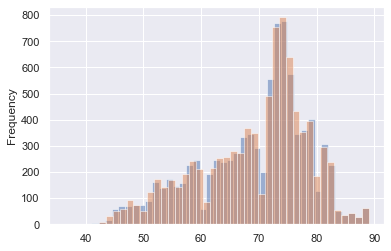

In [38]:
drawDist(clean_life_expectancy_df["Life expectancy"],"")
drawDist(life_expectancy_df_melted["Life expectancy"],"")

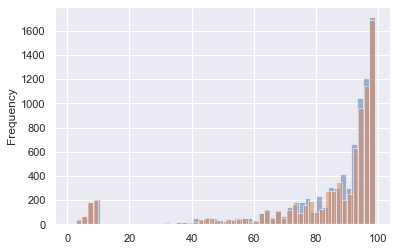

In [39]:
drawDist(clean_life_expectancy_df["Immunization coverage"],"")
drawDist(life_expectancy_df_melted["Immunization coverage"],"")

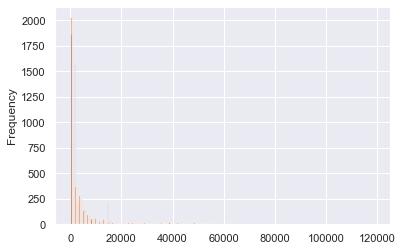

In [40]:
drawDist(clean_life_expectancy_df["GDP"],"")
drawDist(life_expectancy_df_melted["GDP"],"")

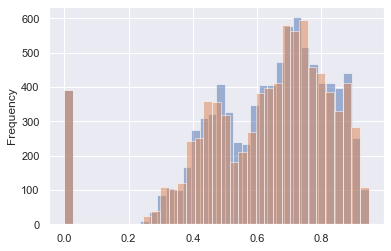

In [41]:
drawDist(clean_life_expectancy_df["Income composition of resources"],"")
drawDist(life_expectancy_df_melted["Income composition of resources"],"")

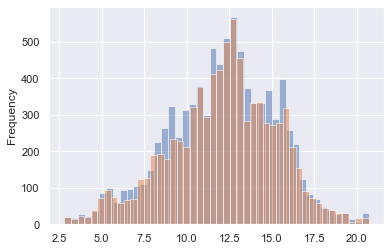

In [42]:
drawDist(clean_life_expectancy_df["Schooling"],"")
drawDist(life_expectancy_df_melted["Schooling"],"")

As we can see the distribution is maintained mostly.

### cleaning done, lets visualise nans to make sure no nans exist anymore

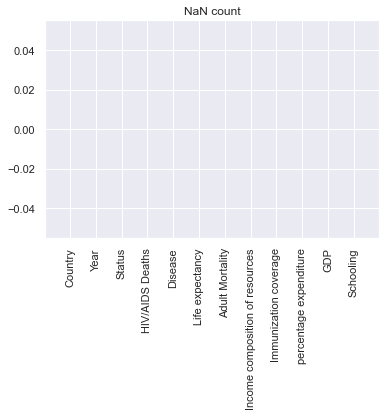

In [43]:
visualiseNaNCount(clean_life_expectancy_df)

No more nans!

###### As we can see, the values that used to be null are not null anymore. Imputing by regression = success!




We can sum up our imputation process in 4 broad steps:
1. Is there a relation between missing enteries and other variables?
2. Check correlation of column with missing variables with other columns to select suitable parameters that can approximate the nans.
3. Check if parameters contain nulls, if yes check the distribution of the parameters. If it is normal we can use mean as a placeholder value, if not median / random samples might be a better solution.
4. Train model and fit it, replace nans with predicted values from model.
5. Merge what we have just imputed into the main dataset.
6. Repeat for all features that need imputing

# Outlier detection

Aim: check if there are any error values
We implement 2 functions to help us identify outliers.
1. box_plot: plots a box plot to visualise the outliers
2. get_outlier_df: computes IQR and returns the dataframe that contains the records that contain outlier values

We have noticed that adult mortality contains a lot of wrong values, eg all years have an adult mortality of 100 and one or two years contain a mortality of 10, almost always with a factor of 10. Such drastic change cannot happen in one year so we impute these values using the median. We detect that a value is an outlier 

In [44]:
#clean_life_expectancy_df.groupby(["Country"])
def outlier_detection(clean_life_expectancy_df):
    life_separated = [y for x, y in clean_life_expectancy_df.groupby('Country', as_index=False)]
    #display(life_separated[0]) #separate the df by country
    for i in range(0, len(life_separated)):
        life_copy = (life_separated[i]).copy(deep = True)
        life_copy.loc[life_copy["Adult Mortality"].median() - life_copy["Adult Mortality"]  >= life_copy["Adult Mortality"] * 10 , ["Adult Mortality"]] =life_copy["Adult Mortality"].median()
        life_separated[i]=life_copy
#         if(i==0):
#             display(life_separated[i])
    life_expectancy_corrected = pd.DataFrame()
    for df in life_separated:
        life_expectancy_corrected=pd.concat([life_expectancy_corrected, df])
    return life_expectancy_corrected

        
        

In [45]:
life_expectancy_corrected = outlier_detection(clean_life_expectancy_df)
clean_life_expectancy_df=life_expectancy_corrected
clean_life_expectancy_df.head(20)

,Country,Year,Status,HIV/AIDS Deaths,Disease,Life expectancy,Adult Mortality,Income composition of resources,Immunization coverage,percentage expenditure,GDP,Schooling
0,Afghanistan,2015,Developing,0.1,Hepatitis B,65.0,263.0,0.479,65.0,71.279624,584.259210,10.1
1,Afghanistan,2014,Developing,0.1,Hepatitis B,59.9,271.0,0.476,62.0,73.523582,612.696514,10.0
2,Afghanistan,2013,Developing,0.1,Hepatitis B,59.9,268.0,0.470,64.0,73.219243,631.744976,9.9
3,Afghanistan,2012,Developing,0.1,Hepatitis B,59.5,272.0,0.463,67.0,78.184215,669.959000,9.8
4,Afghanistan,2011,Developing,0.1,Hepatitis B,59.2,275.0,0.454,68.0,7.097109,63.537231,9.5
5,Afghanistan,2010,Developing,0.1,Hepatitis B,58.8,279.0,0.448,66.0,79.679367,553.328940,9.2
6,Afghanistan,2009,Developing,0.1,Hepatitis B,58.6,281.0,0.434,63.0,56.762217,445.893298,8.9
7,Afghanistan,2008,Developing,0.1,Hepatitis B,58.1,287.0,0.433,64.0,25.873925,373.361116,8.7
8,Afghanistan,2007,Developing,0.1,Hepatitis B,57.5,295.0,0.415,63.0,10.910156,369.835796,8.4
9,Afghanistan,2006,Developing,0.1,Hepatitis B,57.3,295.0,0.405,64.0,17.171518,272.563770,8.1


In [46]:
def box_plot(dataframe, feature):
    data_to_plot =[np.array(dataframe[feature])]

    # Create a figure instance
    fig = plt.figure(1, figsize=(9, 6))

    # Create an axes instance
    ax = fig.add_subplot(111)

    # Create the boxplot
    bp = ax.boxplot(data_to_plot)

In [47]:
def get_outlier_df(dataframe, column):
    #Calculating the First Quartile and Third Quartile and Interquartile Range and lower and upper fence for column
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    Lower_Fence = Q1 - (1.5 * IQR)
    Upper_Fence = Q3 + (1.5 * IQR)
    outliers_rows=pd.concat([dataframe.loc[dataframe[column] > Upper_Fence] ,dataframe.loc[dataframe[column] < Lower_Fence]] )
    return outliers_rows
    

#### life expectancy

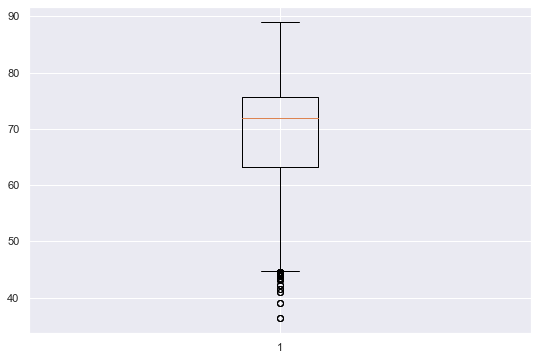

In [48]:
box_plot(clean_life_expectancy_df, "Life expectancy")

In [49]:
life_expectancy_outliers = get_outlier_df(clean_life_expectancy_df, "Life expectancy")
life_expectancy_outliers

,Country,Year,Status,HIV/AIDS Deaths,Disease,Life expectancy,Adult Mortality,Income composition of resources,Immunization coverage,percentage expenditure,GDP,Schooling
1127,Haiti,2010,Developing,1.9,Hepatitis B,36.3,682.0,0.470,78.5,36.292918,662.279518,8.6
4065,Haiti,2010,Developing,1.9,Polio,36.3,682.0,0.470,66.0,36.292918,662.279518,8.6
7003,Haiti,2010,Developing,1.9,Diphtheria,36.3,682.0,0.470,66.0,36.292918,662.279518,8.6
1484,Lesotho,2005,Developing,34.8,Hepatitis B,44.5,675.0,0.437,87.0,57.903698,862.946312,10.7
4422,Lesotho,2005,Developing,34.8,Polio,44.5,675.0,0.437,88.0,57.903698,862.946312,10.7
7360,Lesotho,2005,Developing,34.8,Diphtheria,44.5,675.0,0.437,89.0,57.903698,862.946312,10.7
1582,Malawi,2003,Developing,24.2,Hepatitis B,44.6,613.0,0.362,84.0,4.375316,26.152517,10.3
1583,Malawi,2002,Developing,24.7,Hepatitis B,44.0,67.0,0.388,64.0,3.885395,29.979898,10.4
1584,Malawi,2001,Developing,25.1,Hepatitis B,43.5,599.0,0.387,88.5,12.797606,146.761540,10.1
1585,Malawi,2000,Developing,25.5,Hepatitis B,43.1,588.0,0.391,82.0,13.762702,153.259487,10.7


The life expectancy oulier values are plausible values. As we can see the outliers are mostly values that belong to developing countries with very low life expectancy and high adult mortality. Therefore we will not be imputing these values

#### Adult mortality

,Country,Year,Status,HIV/AIDS Deaths,Disease,Life expectancy,Adult Mortality,Income composition of resources,Immunization coverage,percentage expenditure,GDP,Schooling
345,Botswana,2006,Developing,14.4,Hepatitis B,54.8,491.0,0.610,93.0,76.318679,5374.554867,11.9
346,Botswana,2005,Developing,20.6,Hepatitis B,51.7,566.0,0.593,92.0,629.842564,5351.253732,11.9
347,Botswana,2004,Developing,28.4,Hepatitis B,48.1,652.0,0.580,91.0,469.582390,4896.583835,11.8
348,Botswana,2003,Developing,31.9,Hepatitis B,46.4,693.0,0.567,9.0,299.367125,4163.659600,11.8
349,Botswana,2002,Developing,34.6,Hepatitis B,46.0,699.0,0.558,88.0,6.330007,355.618382,11.9
...,...,...,...,...,...,...,...,...,...,...,...,...
8808,Zimbabwe,2005,Developing,30.3,Diphtheria,44.6,717.0,0.406,68.0,8.717409,444.765750,9.3
8809,Zimbabwe,2004,Developing,33.6,Diphtheria,44.3,723.0,0.407,65.0,63.520507,454.366654,9.2
8810,Zimbabwe,2003,Developing,36.7,Diphtheria,44.5,715.0,0.418,68.0,63.441669,453.351155,9.5
8812,Zimbabwe,2001,Developing,42.1,Diphtheria,45.3,686.0,0.427,75.0,70.835285,548.587312,9.8


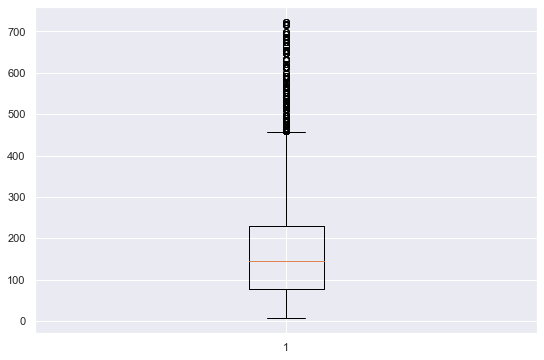

In [50]:
box_plot(clean_life_expectancy_df, "Adult Mortality")
Adult_mortality_outliers = get_outlier_df(clean_life_expectancy_df, "Adult Mortality")
Adult_mortality_outliers

Adult mortality values that are outliers are high values. As we can see these values belong to developing countries. One of them is Botswana which has struggled with HIV/AIDS infections. So a high adult mortality value in such countries is plausible and explainable therefore we will not be impute them.

#### GDP

array(['Antigua and Barbuda', 'Argentina', 'Australia', 'Austria',
       'Bahrain', 'Barbados', 'Belgium', 'Brazil', 'Brunei Darussalam',
       'Canada', 'Chile', 'Croatia', 'Cyprus', 'Czechia', 'Denmark',
       'Equatorial Guinea', 'Estonia', 'Finland', 'France', 'Germany',
       'Greece', 'Hungary', 'Iceland', 'Ireland', 'Israel', 'Italy',
       'Japan', 'Kuwait', 'Latvia', 'Libya', 'Lithuania', 'Luxembourg',
       'Malta', 'Netherlands', 'New Zealand', 'Norway', 'Oman', 'Panama',
       'Poland', 'Portugal', 'Qatar', 'Russian Federation',
       'Saudi Arabia', 'Seychelles', 'Singapore', 'Slovakia', 'Slovenia',
       'Spain', 'Sweden', 'Switzerland', 'Trinidad and Tobago',
       'United Arab Emirates',
       'United Kingdom of Great Britain and Northern Ireland',
       'United States of America', 'Uruguay'], dtype=object)

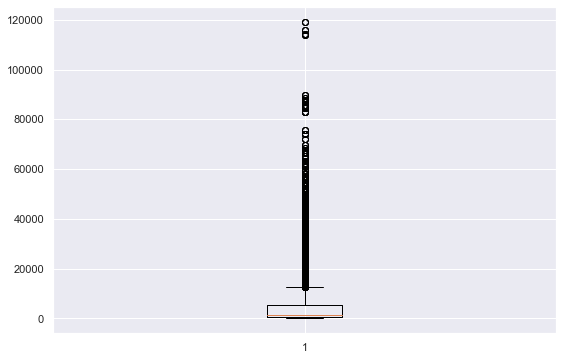

In [51]:
box_plot(clean_life_expectancy_df, "GDP")
GDP_outliers = get_outlier_df(clean_life_expectancy_df, "GDP")
GDP_outliers.Country.unique()

Most of the countries that have a GDP higher than usual belong to the developed countries class. Them being outliers ie expected as the dataset is imbalanced and contains more developing countries than developed countries. The GDP are plausible and therfore will not be imputed.

#### Immunization coverage

,Country,Year,Status,HIV/AIDS Deaths,Disease,Life expectancy,Adult Mortality,Income composition of resources,Immunization coverage,percentage expenditure,GDP,Schooling
2938,Afghanistan,2015,Developing,0.1,Polio,65.0,263.0,0.479,6.0,71.279624,584.259210,10.1
2949,Afghanistan,2004,Developing,0.1,Polio,57.0,293.0,0.381,5.0,15.296066,219.141353,6.8
2950,Afghanistan,2003,Developing,0.1,Polio,56.7,295.0,0.373,41.0,11.089053,198.728544,6.5
2951,Afghanistan,2002,Developing,0.1,Polio,56.2,284.0,0.341,36.0,16.887351,187.845950,6.2
2952,Afghanistan,2001,Developing,0.1,Polio,55.3,316.0,0.340,35.0,10.574728,117.496980,5.9
...,...,...,...,...,...,...,...,...,...,...,...,...
8790,Zambia,2007,Developing,13.6,Diphtheria,52.6,487.0,0.492,8.0,10.851482,114.587985,11.1
2927,Zimbabwe,2010,Developing,15.7,Hepatitis B,52.4,527.0,0.436,9.0,53.308581,713.635620,10.0
2934,Zimbabwe,2003,Developing,36.7,Hepatitis B,44.5,715.0,0.418,7.0,63.441669,453.351155,9.5
5872,Zimbabwe,2003,Developing,36.7,Polio,44.5,715.0,0.418,7.0,63.441669,453.351155,9.5


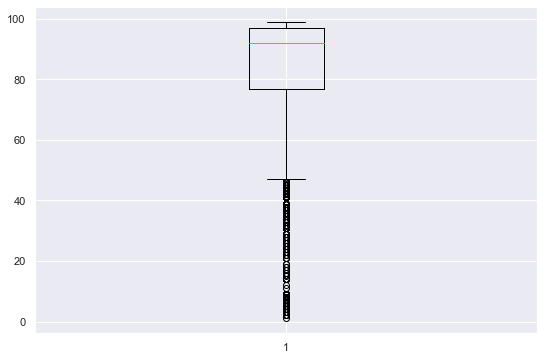

In [52]:
box_plot(clean_life_expectancy_df, "Immunization coverage")
Immunization_coverage_outliers = get_outlier_df(clean_life_expectancy_df, "Immunization coverage")
Immunization_coverage_outliers

The outlier values belong to developing countries with low life expectancy. The low immunity scores are explainable.

#### Income composition of resources

array(['Antigua and Barbuda', 'Bahamas', 'Bhutan',
       'Bosnia and Herzegovina', 'Burkina Faso', 'Cabo Verde', 'Chad',
       'Comoros', 'Equatorial Guinea', 'Eritrea', 'Ethiopia', 'Georgia',
       'Grenada', 'Guinea-Bissau', 'Kiribati', 'Lebanon', 'Madagascar',
       'Micronesia (Federated States of)', 'Montenegro', 'Nigeria',
       'Oman', 'Saint Lucia', 'Saint Vincent and the Grenadines',
       'Seychelles', 'South Sudan', 'Suriname',
       'The former Yugoslav republic of Macedonia', 'Timor-Leste',
       'Turkmenistan', 'Uzbekistan', 'Vanuatu'], dtype=object)

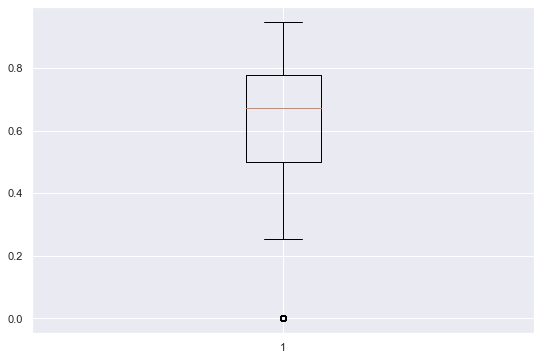

In [53]:
box_plot(clean_life_expectancy_df, "Income composition of resources")
income_outliers = get_outlier_df(clean_life_expectancy_df, "Income composition of resources")
income_outliers.Country.unique()

There are very few outlier values 

#### HIV/AIDS deaths

array(['Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi',
       'Cambodia', 'Cameroon', 'Central African Republic', 'Chad',
       'Congo', "Côte d'Ivoire", 'Democratic Republic of the Congo',
       'Djibouti', 'Dominican Republic', 'Equatorial Guinea', 'Eritrea',
       'Ethiopia', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau',
       'Guyana', 'Haiti', 'Jamaica', 'Kenya', 'Lesotho', 'Liberia',
       'Malawi', 'Mali', 'Mozambique', 'Namibia', 'Nigeria', 'Rwanda',
       'Sierra Leone', 'South Africa', 'South Sudan', 'Swaziland', 'Togo',
       'Trinidad and Tobago', 'Uganda', 'United Republic of Tanzania',
       'Zambia', 'Zimbabwe'], dtype=object)

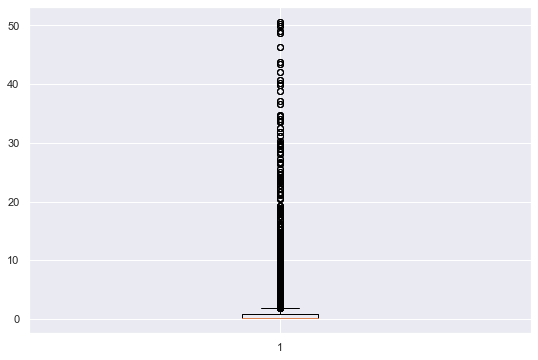

In [54]:
box_plot(clean_life_expectancy_df, "HIV/AIDS Deaths")
hiv_outliers = get_outlier_df(clean_life_expectancy_df, "HIV/AIDS Deaths")
hiv_outliers.Country.unique()

The values that have a high HIV/AIDS deaths belong to developing countries with low immunization coverage against HIV. Thus this behaviour is expected

#### Schooling

array(['Burkina Faso', 'Djibouti', 'Niger'], dtype=object)

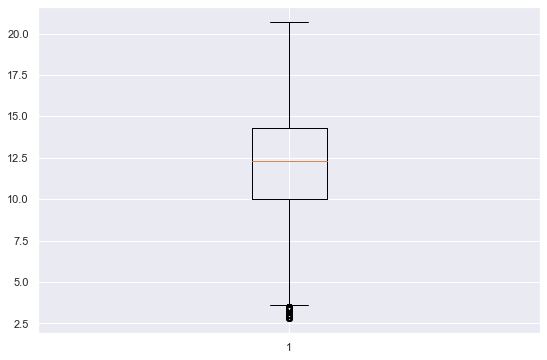

In [55]:
box_plot(clean_life_expectancy_df, "Schooling")
schooling_outliers = get_outlier_df(clean_life_expectancy_df, "Schooling")
schooling_outliers.Country.unique()

The values that belong to low schooling years are developing countries that typuically suffer with education, so we will not be imputing the values.

# Exporting dataset

In [56]:
#drop columns that we wont be analysing
clean_life_expectancy_df.drop(columns=["percentage expenditure"], inplace = True)
root_path='Cleaned_data/'
clean_life_expectancy_df
clean_life_expectancy_df.to_csv(root_path+'Life Expectancy Data.csv')

_Refrences:_

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3074241/

https://stats.stackexchange.com/questions/421545/multiple-imputation-by-chained-equations-mice-explained/421586

https://www.statisticshowto.com/choose-bin-sizes-statistics/